# "Modulo 1"
> "Analisi Monte-Carlo della termodinamica di network random"

In [1]:
#collapse
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.sparse as ss
from math import *
rng = np.random.default_rng()

In questa relazione mi occuperò di studiare la termodinamica di un sistema tipo Ising, ma con interazioni a lunga distanza tra elementi casuali del network. 
Per farlo inizieremo prima dall'implementazione di un modello di Ising 2D classico per poi generalizzarlo e applicarlo al caso di interesse.

L'Hamiltoniana del modello di **Ising 2D classico** è:
 $$H=-\sum_{<i,j>}J_{ij}s_i s_j-\sum_j h_j s_j$$
dove gli $s_i$ sono i valori che ogni elemento del sistema può assumere e possono essere $\pm 1$, versione classica dello spin-$\frac{1}{2}$, $J_{ij}$ rappresenta la matrici degli accoppiamenti tra $s_i$ ed $s_j$ e $h_j$ è il valore del campo magnetico esterno per ogni sito $j$. La prima somma è estesa a tutti gli $i$ e $j$ primi vicini, mentre la seconda a tutti gli elementi.
I segni nell'Hamiltoniana sono convenzionali ed implicano che per valori di $J_{ij}$ positivi una coppia di elementi rende minima l'energia quando i valori dei due spin sono concordi, per $J_{ij}=0$ i due elementi sono non interagenti, mentre per $J_{ij}$ negativi la configurazione che minimizza l'energia è quella con gli spin antiparalleli.
Per questo primo esempio verrà considerato un modello di Ising standard, per cui si considera $J_{ij}=J$ e $h_i=h$ uniformi, quindi uguali per ogni elemento o coppia di elementi. 

Lo scopo delle nostre analisi sarà quella di studiare la stabilità della fase **ferromagnetica** al variare dell'inverso della temperatura $\beta$, quindi considereremo sempre $J$ positivo e per semplificare la trattazione di valore unitario. 
Studiando il sistema infatti è stato dimostrato che è presente una transizione di fase ad una temperatura critica $T_c$, a cui è associata un $\beta_c$. Il parametro d'ordine che individua la transizione è la magnetizzazione $⟨M⟩$ definita come:
$$⟨M⟩=\sum_{i=1}^N s_i$$ o la densità di magnetizzazione $⟨m⟩=\frac{1}{N}⟨M⟩=\frac{1}{N}\sum_{i=1}^N s_i$

Infatti si può dimostrare che passando da $\beta<\beta_c$ a $\beta>\beta_c$ il sistema passa da una configurazione disordinata di spin, per cui $⟨M⟩= 0$, ad una ordinata, per cui $⟨M⟩\neq 0$.

Detta $\sigma$ una generica configurazione di spin, la probabilità che tale configurazione si verifichi per un certo valore di $\beta$ è data dalla distribuzione di Boltzmann:
$$P(\sigma)=\frac{1}{Z}e^{-\beta H(\sigma)}$$
dove $Z=\int e^{-\beta H(\sigma)}$ è detta funzione di partizione e costituisce la costante di normalizzazione. 
Nota $P(\sigma)$ è possibile calcolare, in principio, qualsiasi grandezza fisica maroscopica, come ad esempio l'energia o la magnetizzazione media associate ad una certa configurazione come:
$$⟨m⟩=\sum_\alpha m(\alpha)P(\alpha) \quad o \quad ⟨\epsilon⟩=\sum_\alpha \epsilon(\alpha)P(\alpha)$$


Le grandezze termodinamiche calcolate nei passaggi seguenti sono:
* Densità di energia media $⟨\epsilon⟩=⟨E⟩/N $
* Densità del valore assoluto della magnetizzazione $⟨m⟩=⟨M⟩/N = (\sum_i s_i)/N $
* Calore specifico $c\equiv \frac{\partial ⟨\epsilon⟩}{\partial T} \propto N(⟨\epsilon^2⟩-⟨\epsilon⟩^2) $
* Suscettività magnetica $\chi \equiv \frac{\partial ⟨m⟩}{\partial h} \propto N(⟨m^2⟩-⟨m⟩^2) $



## Metodo Monte-Carlo

Lo studio sarà fatto attraverso un'analisi Monte-Carlo: una famiglia di metodi computazionali basati sul campionamento random delle possibili realizzazioni del sistema, che sono pesate da una distribuzione di probabilità legata il modello trattato. Attraverso questo campionamento casuale si cerca di esplorare tutto lo spazio delle configurazioni per poi andare a calcolare le osservabili di interesse sul campione finale. L'algoritmo Monte-Carlo utilizzato si basa su una catena di Markov, che si ottiene estraendo le varie configurazioni attraverso la distribuzione di Boltzmann.

Esistono vari algoritmi che soddisfano le condizioni richieste dai metodi Monte-Carlo, uno dei più usati, che è stato usato anche per lo studio dei sistemi in questa relazione, è il cosiddetto algoritmo Metropolis. L'implementazione richiederebbe l'uso di un generatore di numeri random, ma nella pratica vengono utilizzate routine che producono numeri detti pseudo-random attraverso algoritmi che garantiscono, entro certi limiti, numeri scorrelati tra loro e una distribuzione uniforme.

Un esempio di **generatore di numeri pseudo-random** è riportato nel codice sottostante, che rientra nella categoria dei cosiddetti *generatori congruenti lineari*, ovvero dove partendo da un certo valore $x_0$ la successione dei numeri pseudo casuali viene generata attraverso:
$$X_{i+1}=mod(aX_i+c,m)$$
Per certi valori dei parametri è dimostrato che questa successione si comporta piuttosto bene come generatore, in questo caso sono stati utilizzati:
$$a=16807, \quad c=0, \quad m=2^{31}-1$$

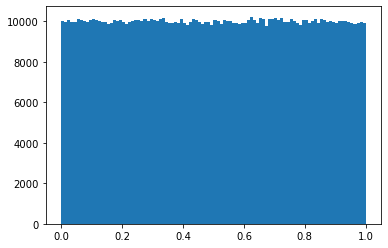

In [3]:
def rando(N,x0,ini,fin):
    x=np.zeros((N+2))
    a=16807   
    c=0     
    e=31      
    m=2**e-1

    x[0]=x0   # initial value

    for i in range(N+1):
        x[i+1]=(a*x[i]+c)%m
        
    return x[2:]/m*(fin-ini) + ini


x=rando(1000000,101,0,1)


plt.hist(x,100,rwidth=1)
plt.show()

Come si può notare dall'istogramma precedente la distribuzione dei valori risulta piuttosto uniforme per un gran numero di estrazioni, condizione necessaria, ma comunque non sufficiente a dimostrare che si tratti di un buon generatore.

Nei codici seguenti però è stato utilizzato un generatore di numeri pseudo-random presente all'interno della libreria NumPy, poichè risulta più sicuro e più facile da implementare.

## Algoritmo Metropolis

Tra tutte le implementazioni che soddisfano alcune condizioni necessarie per il corretto funzionamento del Monte-Carlo, come quella di equilibrio, e altre condizioni utili seppur non necessarie, come il bilancio dettagliato, una classe di algoritmi tra i più efficienti è il Metropolis. Per descrivere il funzionamento del Metropolis è necessario descrivere il processo stocastico che permette di passare da uno stato $a$ ad uno stato $b$ in un passo elementare della catena, ovvero bisogna definire la probabilità della transizione. Detta $p_i$ la probabilità di realizzazione della configurazione $i$, l'algoritmo si può articolare come segue:

* A partire dallo stato di partenza $a$ si seleziona uno stato $\tilde{b}$ a partire da una probabilità di transizione di prova
* Se risulta che $p_{\tilde{b}}>p_a$ allora si accetta $\tilde{b}$ come stato successivo $b$
* Se invece $p_{\tilde{b}}<p_a$ allora si accetta $b=\tilde{b}$ con probabilità $p_{\tilde{b}}/p_a$, e $a=b$ altrimenti.



## Implementazione
Per l'implementazione dell'algoritmo sono state create alcune funzioni:

* Una che definisce lo stato iniziale: dato il numero di siti fornisce uno stato "caldo" con gli spin scelti tutti casualmente o "freddo" con gli spin tutti orientati nella stessa direzione, o +1 o -1

In [3]:
#collapse
def initialstate(N, random=True, cold=+1):
    if random:
        state = 2*rng.integers(2, size=(N,N))-1
    elif cold== 1:
        state = np.int_(np.ones((N,N)))
    elif cold== -1:
        state = -np.int_(np.ones((N,N)))
    else:
        return print("Put cold = +1 or -1")
    return state

* Il passo del Metropolis è implementato dalla funzione *mcmove*, che prende in input la configurazione precedente, il valore di $\beta$, ovvero l'inverso della temperatura, e la matrice di adiacenza del sistema considerato. La funzione restituisce la configurazione scelta attraverso il Metropolis.

In [4]:
#collapse
def mcmove(config, beta):
    "Monte Carlo move using Metropolis algorithm"
    for i in range(N):
        for j in range(N):
            a = rng.integers(N)
            b = rng.integers(N)
            s =  config[a, b]
            cf = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
            cost = 2*s*cf
            if cost < 0:
                s = -s
            elif rng.random() < np.exp(-cost*beta):
                s = -s
            config[a,b] = s
    return config

* Le seguenti funzioni calcolano rispettivamente l'energia e la magnetizzazione della configurazione di spin in input.

In [5]:
#collapse
def calcEnergy(config):
    "Energy of a given configuration"
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            h = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -h*S
    return energy/4

def calcMag(config):
    "Magnetization of a given configuration"
    mag = np.sum(config)
    return mag


* La funzione che restituisce la suscettività magnetica o il calore specifico.

In [8]:
#collapse
def Di(Vet):
    return (np.mean((Vet*nn)**2)-(np.mean(Vet*nn))**2)/nn


Inoltre per ogni grandezza è stato calcolato l'errore per ogni punto. Infatti ogni punto di grafici rappresenterà la media di un gran numero di realizzazioni ottenute con gli stessi parametri. A questa distribuzione è associata anche una varianza che è stata calcolata, per le prime due grandezze, come:
$$\sigma^2=\frac{1}{N}\frac{1}{N-1} \sum_{j=1}^N (x_j-\bar{x})^2$$

Questa grandezza è un buon stimatore della varianza per campioni statistici scorrelati, ma può sottostimare la varianza effettiva se ci sono correlazioni tra i vari punti. L'algoritmo sottostante è stato implementato considerando un numero di passi di decorrelazione tra una misurazione e un'altra, in modo che ogni passo Metropolis sia scorrelato dal precedente. Questa precauzione fa sì che la stima della varianza come sopra sia corretta per le prime due grandezze, ma potrebbe non essere altrettanto buona per le ultime due, per le quali si è utilizzato il metodo del **Bootstrap** per campioni correlati.

Il metodo consiste nel rimescolare il campione, attraverso dei numeri pseudo-random, e per ogni "nuovo" campione calcolarne la media. Alla fine la varianza delle medie dei nuovi campioni approssima meglio il valore della varianza del campione iniziale, ma per campioni correlati bisogna aggiungere l'accortezza di rimescolare il campione iniziale in blocchi, invece che per singoli elementi, in modo da considerare anche eventuali correlazioni esistenti.






* La funzione che restituisce la varianza relativa alle grandezze calcolate con la funzione precedente, calcolata attraverso il metodo del Bootstrap.

In [9]:
#collapse
def boots(v,M,MM):
    N=len(v)
    y=np.zeros((M,N))
    
    for i in range(M):
        nr=rng.integers((N-MM), size=N//MM)
        
        for j in range(0,N//MM):
            y[i,j:j+MM]=v[int(nr[j]):int(nr[j])+MM]
    
    FF=np.zeros(M)
    for i in range(M):
        FF[i]=Di(y[i])/MM
        
    return np.mean((FF-np.mean(FF))**2) 

## Modello di Ising 2D classico

A questo punto è possibile scrivere il codice che implementa l'algoritmo Metropolis e calcola le variabili termodinamiche di interesse. 
Nell'esempio seguente è stata eseguita una simulazione per un modello di Ising 2D classico.

Per la seguente simulazione i parametri del Metropolis sono:
* Reticolo di $15\times 15$ elementi
* 50 punti relativi a valori di $\beta$ compresi tra 0 e 1
* 400 passi Metropolis per ogni $\beta$
* 40 passi di decorrelazione per ogni passo Metropolis
* 100 ricampionamenti per il Bootstrap
* 50 elementi per blocco nel Bootstrap

In [ ]:
#collapse
nB      = 50       #  number of points of beta
decSteps= 40       #  number of MC sweeps for decorrelation
mcSteps = 400      #  number of MC sweeps for calculation

beta    = np.linspace(0, 1, nB)
N=15

E,M,C,X,varX,varC,varE,varM = np.zeros((nB)), np.zeros((nB)), np.zeros((nB)), np.zeros((nB)), np.zeros((nB)), np.zeros((nB)), np.zeros((nB)), np.zeros((nB))
mn1, mm, nn  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*(mcSteps-1)) , 1/(N*N)

config = initialstate(N)

for bb in range(1,nB):

    Ene=np.zeros(mcSteps)
    Mag=np.zeros(mcSteps)

    iB=beta[bb]; iB2=iB*iB;

    for i in range(mcSteps):         
        for j in range(decSteps):       # steps of decorrelation
            mcmove(config, iB)          # Metropolis step

        Ene[i] = calcEnergy(config)     # calculate the energy
        Mag[i] = calcMag(config)        # calculate the magnetization

    E[bb] = np.sum(Ene)*mn1
    varE[bb] = np.sum((Ene*nn-E[bb])**2)*mm
    M[bb] = np.sum(Mag)*mn1
    varM[bb] = np.sum((Mag*nn-M[bb])**2)*mm
    C[bb] = Di(Ene)
    varC[bb]=boots(Ene,100,50)
    X[bb] = Di(Mag)
    varX[bb]=boots(Mag,100,50)

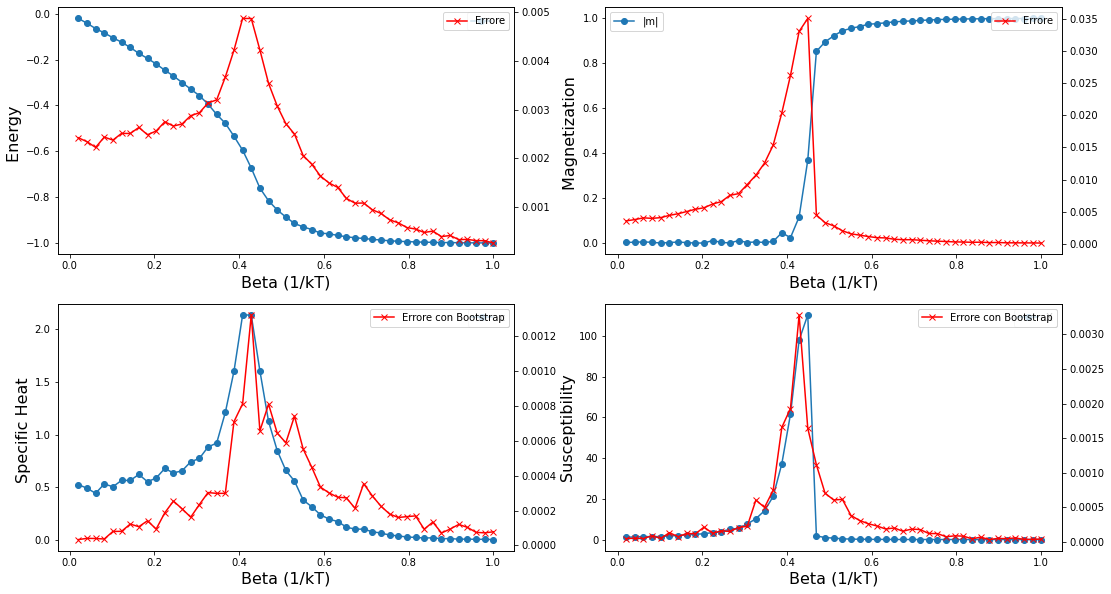

In [12]:
#collapse

beta1=beta[1:]
E1=E[1:]
errE1=np.sqrt(varE[1:])
M1=M[1:]
errM1=np.sqrt(varM[1:])
C1=C[1:]
errC1=np.sqrt(varC[1:])
X1=X[1:]
errX1=np.sqrt(varX[1:])

f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 )
plt.plot(beta1, E1, marker='o',label='e')
plt.legend()
plt.xlabel("Beta (1/kT)", fontsize=16)
plt.ylabel("Energy ", fontsize=16)       
plt.twinx()
plt.plot(beta1,errE1,color="r", marker='x',label='Errore')
plt.legend()

sp =  f.add_subplot(2, 2, 2 )
plt.plot(beta1, abs(M1), marker='o',label='|m|')
plt.legend()
plt.xlabel("Beta (1/kT)", fontsize=16)
plt.ylabel("Magnetization ", fontsize=16)
plt.twinx()
plt.plot(beta1,errM1,color="r", marker='x',label='Errore')
plt.legend()

sp =  f.add_subplot(2, 2, 3 )
plt.plot(beta1, C1, marker='o',label='c')
plt.legend()
plt.xlabel("Beta (1/kT)", fontsize=16)
plt.ylabel("Specific Heat ", fontsize=16)
plt.twinx()
plt.plot(beta1,errC1,color="r", marker='x',label='Errore con Bootstrap')
plt.legend()

sp =  f.add_subplot(2, 2, 4 )
plt.plot(beta1, X1, marker='o',label="X")
plt.legend()
plt.xlabel("Beta (1/kT)", fontsize=16) 
plt.ylabel("Susceptibility", fontsize=16)
plt.twinx()
plt.plot(beta1,errX1,color="r", marker='x',label='Errore con Bootstrap')
plt.legend()

plt.show()

Nei grafici sopra i punti in blu rappresentano le medie delle grandezze specificate a sinistra di ogni grafico per ogni valore di $\beta$, mentre in rosso sono gli errori associati al valore della funzione corrispondente allo stesso $\beta$, per i grafici in alto l'errore è calcolato come la radice quadrata della varianza standard, mentre per i due in basso come la radice della varianza calcolata con il metodo del Bootstrap.
    La costante $h$ che parametrizza il campo magnetico esterno agente sul sistema, in questa simulazione è stata considerata nulla. 

Come possiamo notare dai grafici, risulta evidente la presenza di un punto di transizione dalla fase paramagnetica a quella ferromagnetica al crescere di $\beta$, infatti il valore assoluto della magnetizzazione presenta una netta crescita per valori di $\beta$ intorno a 0.44 come previsto analiticamente e la suscettività magnetica associata presenta un picco nello stesso range di valori. 

Al punto critico di un sistema fisico, in teoria, il picco della suscettività dovrebbe divergere, questo in un sistema simulato non può succedere in quanto si tratta comunque di un sistema di taglia finita in cui la lunghezza di correlazione non può diventare infinita, per cui si parla di $\beta$ semicritico per taglie finite, ma se ne può studiare l'andamento, come vedremo in seguito.

La transizione di fase si può apprezzare anche osservando l'andamento delle varianze associate ad ogni osservabile. Esse infatti presentano tutte un netto picco per valori corrispondenti a quelli del punto critico, sia che sia calcolata nel modo standard, come nel caso dell'energia e della magnetizzazione, sia che sia calcolata attraverso Bootstrap.

Per assicurarci però che si tratti di una vera transizione di fase procediamo con l'anailsi attraverso il *Finite Size Scaling*, che, se dovesse far combaciare i grafici relativi a sistemi di taglia diversa, ci assicurerebbe allo stesso tempo due importanti proprietà: la prima che la lunghezza di correlazione diverge, effetto caratteristico della transizione di fase, la seconda che gli esponenti critici utilizzati sono giusti e quindi il sistema appartiene alla giusta classe di universalità. 

Gli esponenti critici calcolati analiticamente relativi al modello di Ising 2D classico sono:

$$\beta=1/8, \quad \gamma=7/4, \quad   \nu=1, \quad    \alpha=0$$

La simulazione seguente è stata eseguita con gli stessi parametri per tutte le varie taglie (10, 15 ,20) del sistema e i risultati sono riportati con le barre di errore calcolate come prima.

In [ ]:
#collapse
nB      = 50       #  number of points of beta
decSteps= 100       #  number of MC sweeps for decorrelation
mcSteps = 300      #  number of MC sweeps for calculation

beta    = np.linspace(0.35, 0.6, nB)
linell  = np.array([10,15,20])
Nell=linell.size

E,M,C,X,varX,varC,varE,varM = np.zeros((nB,Nell)), np.zeros((nB,Nell)), np.zeros((nB,Nell)), np.zeros((nB,Nell)), np.zeros((nB,Nell)), np.zeros((nB,Nell)), np.zeros((nB,Nell)), np.zeros((nB,Nell))

for Ni in range(Nell):    
    
    N=linell[Ni]          # DIMENSIONI VARIABILI
    
    mn1, mm, nn  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*(mcSteps-1)) , 1/(N*N) 

    config = initialstate(N)

    for bb in range(1,nB):

        Ene=np.zeros(mcSteps)
        Mag=np.zeros(mcSteps)

        iB=beta[bb]; iB2=iB*iB;

        for i in range(mcSteps):         
            for j in range(decSteps):       # steps of decorrelation
                mcmove(config, iB)          # Metropolis step

            Ene[i] = calcEnergy(config)     # calculate the energy
            Mag[i] = calcMag(config)        # calculate the magnetization

        
        E[bb,Ni] = np.sum(Ene)*mn1
        varE[bb,Ni] = np.sum((Ene*nn-E[bb,Ni])**2)*mm
        M[bb,Ni] = np.sum(Mag)*mn1
        varM[bb,Ni] = np.sum((Mag*nn-M[bb,Ni])**2)*mm
        C[bb,Ni] = Di(Ene)
        varC[bb,Ni]=boots(Ene,50,40)
        X[bb,Ni] = Di(Mag)
        varX[bb,Ni]=boots(Mag,50,40)

beta2=beta[1:]
E2=E[1:]
errE2=np.sqrt(varE[1:])
M2=M[1:]
errM2=np.sqrt(varM[1:])
C2=C[1:]
errC2=np.sqrt(varC[1:])
X2=X[1:]
errX2=np.sqrt(varX[1:])

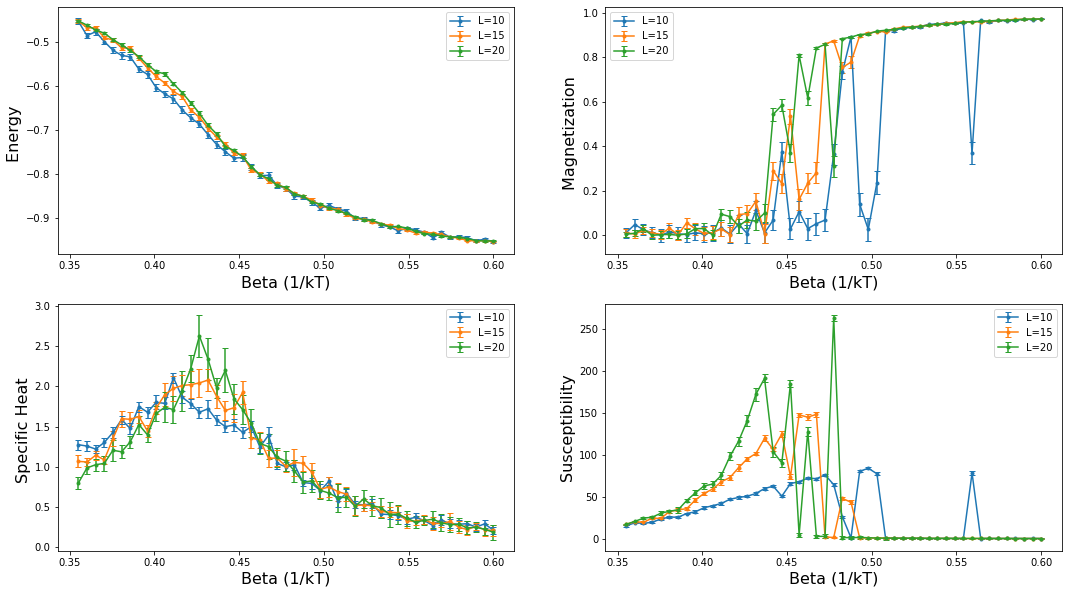

In [18]:
#collapse
import matplotlib as mpl
mpl.rcParams['errorbar.capsize'] = 3


f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 )
for i in range(Nell):
    plt.errorbar(beta2, E2[:,i],yerr=errE2[:,i],label="L="+str(linell[i]), marker='.')
plt.xlabel("Beta (1/kT)", fontsize=16)
plt.ylabel("Energy ", fontsize=16)       
plt.legend()

sp =  f.add_subplot(2, 2, 2 )
for i in range(Nell):
    plt.errorbar(beta2, abs(M2)[:,i],yerr=errM2[:,i],label="L="+str(linell[i]), marker='.')
plt.xlabel("Beta (1/kT)", fontsize=16)
plt.ylabel("Magnetization ", fontsize=16)
plt.legend()

sp =  f.add_subplot(2, 2, 3 )
for i in range(Nell):
    plt.errorbar(beta2, C2[:,i],yerr=errC2[:,i]*10,label="L="+str(linell[i]), marker='.')
plt.xlabel("Beta (1/kT)", fontsize=16)
plt.ylabel("Specific Heat ", fontsize=16)
plt.legend()

sp =  f.add_subplot(2, 2, 4 )
for i in range(Nell):
    plt.errorbar(beta2, X2[:,i],yerr=errX2[:,i]*100,label="L="+str(linell[i]), marker='.')
plt.xlabel("Beta (1/kT)", fontsize=16) 
plt.ylabel("Susceptibility", fontsize=16)
plt.legend()

plt.show()

I grafici sopra rappresentano l'andamento delle grandezze specificate per valori di $\beta$ che vanno da 0.35 a 0.5, ovvero in uno stretto intorno del punto critico noto analiticamente $\beta_c \simeq 0.44$ ed ogni colore corrisponde ad una diversa taglia del sistema, riportato in legenda. Essi purtroppo sono affetti da importanti fluttuazioni statistiche dovute principalmente a due fattori:
* in prossimità del punto critico si verifica non solo una divergenza nella lunghezza di correlazione, ma anche nei tempi di correlazione e per avere dei punti più puliti nell'intorno di $\beta_c$ andrebbe aumentato di molto il numero di passi di decorrelazione
* l'implementazione dell'algoritmo complessivo è risultato computazionalmente molto pesante, anche purtroppo perchè scritto in Python, e non è stato possibile aggiungere altre misurazioni e passi di decorrelazione

L'andamento complessivo dei grafici si riesce comunque a distinguere, come il picco nel calore specifico, ma le differenze tra le diverse taglie del sistema sono difficili da notare, seppur presenti.

Considerate queste difficioltà procediamo comunque con lo studio del Finite Size Scaling:

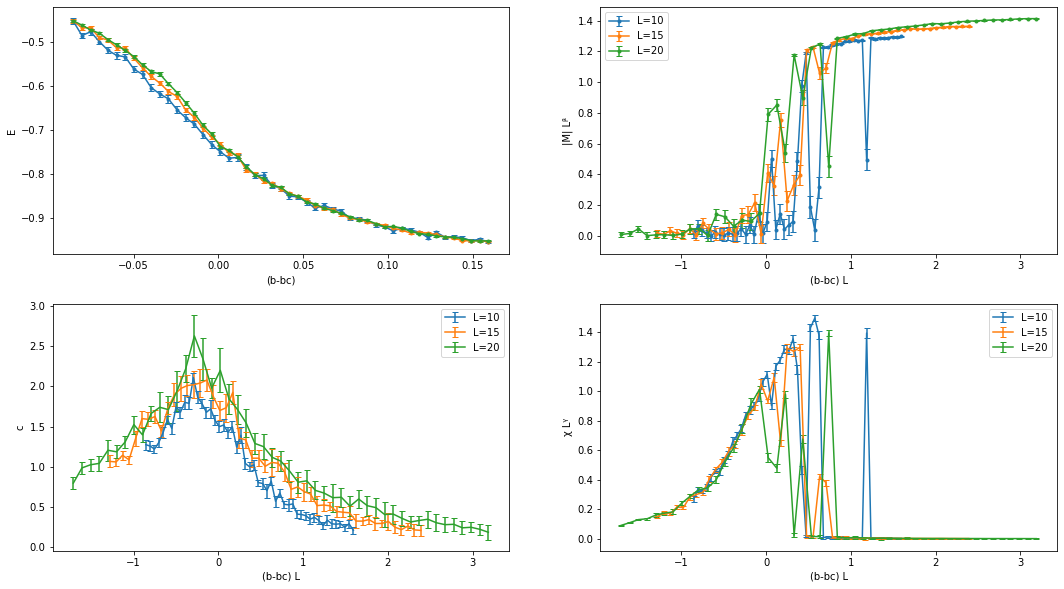

In [22]:
#collapse


Fmagniz=np.zeros((nB,Nell))
Fxi=np.zeros((nB,Nell))
Flins=np.zeros((nB,Nell))
FC=np.zeros((nB,Nell))
FerrE=np.zeros((nB,Nell))
FerrM=np.zeros((nB,Nell))
FerrX=np.zeros((nB,Nell))
FerrC=np.zeros((nB,Nell))

ell1=0
for ell in linell:

    Fmagniz[1:,ell1]=abs(M2)[:,ell1].copy()*(ell)**(1/8)
    Fxi[1:,ell1]=X2[:,ell1].copy()/(ell)**(7/4)
    FC[1:,ell1]=C2[:,ell1].copy()
    Flins[1:,ell1]=(beta2.copy()-0.4406868)*ell
    FerrE[1:,ell1]=errE2[:,ell1].copy()
    FerrM[1:,ell1]=errM2[:,ell1].copy()*(ell)**(1/8)
    FerrX[1:,ell1]=errX2[:,ell1].copy()*100/(ell)**(7/4)
    FerrC[1:,ell1]=errC2[:,ell1].copy()*10
    
    ell1+=1

plt.figure(figsize=(18, 10))

plt.subplot(221)
for i in range(Nell):

    plt.errorbar(beta2-0.4406868, E2[:,i],yerr=errE2[:,i],label="L="+str(linell[i]), marker='.')
plt.xlabel('(b-b𝖼)')
plt.ylabel('E')

plt.subplot(222)
for i in range(Nell):
    #plt.plot(beta2[1:], abs(M2[1:,i]), marker='o',label=linell[i])
    plt.errorbar(Flins[1:,i], Fmagniz[1:,i],yerr=FerrM[1:,i],label="L="+str(linell[i]), marker='.')
plt.xlabel('(b-b𝖼) L')
plt.ylabel('|M| Lᵝ')
plt.legend()


plt.subplot(223)
for i in range(Nell):
    #plt.plot(beta2[1:], C2[1:,i], marker='o',label=linell[i])
    plt.errorbar(Flins[1:,i], FC[1:,i],yerr=FerrC[1:,i],label="L="+str(linell[i]))
plt.xlabel('(b-b𝖼) L')
plt.ylabel('c')
plt.legend()


plt.subplot(224)
for i in range(Nell):
    
    plt.errorbar(Flins[1:,i], Fxi[1:,i],yerr=FerrX[1:,i],label="L="+str(linell[i]))
#plt.plot(Flins[1:],Fxi[1:],marker="o")
plt.xlabel('(b-b𝖼) L')
plt.ylabel('χ Lᵞ')
plt.legend()


plt.show()

Nonostante le difficoltà descritte sopra si può comunque notare che le funzioni tendono a combaciare per ogni taglia del sistema, dopo aver applicato il giusto Finite Size Scaling, prova del fatto che siamo in presenza di un effettivo punto di transizione e che il nostro modello rientra nella giusta classe di universalità.

## Implementazione della matrice di adiacenza

Nei prossimi passaggi verrà implementata la matrice di adiacenza che descrive le interazioni tra i vari elementi del sistema. 
Per definire la matrice di adiacenza è necessario considerare gli elementi del sistema come un vettore e ad ogni interazione tra due elementi del sistema far corrispondere un elemento della matrice di adiacenza diverso da zero. In pratica la topologia del sistema diventa non più fondamentale e si può considerare giacente su una varietà unidimensionale. Quello che diventa fondamentale sono le interazioni tra elementi, rappresentate dalla matrice di adiacenza, che possono essere pure a lunga distanza.

Per andare a controllare il corretto funzionamento dell'implementazione procediamo con lo studio di un sistema con matrice di adiacenza corrispondente a quella di un reticolo bidimensionale, andando poi a confrontare i risultati con quelli ottenuti in precedenza.
Si definisce quindi un ordinamento dei singoli elementi per passare da una matrice $L\times L$ ad un vettore di dimensione $N=L^2$, per un reticolo bidimensionale, mentre $N=L^d$ per un reticolo intero generico d-dimensionale. Su questa premessa si basa la seguente funzione che prende in input la dimensione del reticolo e il numero di elementi per lato e restituisce la matrice di adiacenza $N \times N$ relativa al reticolo.

In [2]:
#collapse
def AdD(d,L):
    # This function returns the sparse adjacency matrix of a d-dimensonal  
        # integer lattice with side L and the total number of elements N=L**d
    # Only for Periodic Boundary Conditions
    
    import scipy.sparse as ss
    N=L**d
    A=ss.dok_matrix((N,N))
    for i in range(N):
        for j in range(d):
            A[i,(i+L**j)%N] = 1
            A[i,(i-L**j)%N] = 1
    return A.copy(), N

Conseguentemente devono essere modificate alcune funzioni usate in precedenza, per passare da una configuazione bidimensionale ad una unidimensionale:

* Quella che definisce stato iniziale:


In [3]:
#collapse
def initialstate2(N, random=True, cold=+1):
    if random:
        state = 2*rng.integers(2, size=(N))-1
    elif cold== 1:
        state = np.int_(np.ones((N)))
    elif cold== -1:
        state = -np.int_(np.ones((N)))
    else:
        return print("Put cold = +1 or -1")
    return state

* La funzione che implememta il passo del Metropolis:


In [4]:
#collapse
def mcmove2(config, beta, A):
    "Monte Carlo move using Metropolis algorithm"
    for i in range(N):
        a = rng.integers(N)
        s =  config[a]
        cost=sum(-(s*A[a])*config)-sum((s*A[a])*config)
        if -cost < 0:
            s = -s
        elif rng.random() < np.exp(cost*beta):
            s = -s
        config[a] = s
    return config

* E il calcolo dell'energia di una configurazione:


In [12]:
#collapse
def calcEnergy2(config):
    "Energy of a given configuration"
    energy = 0
    for i in range(len(config)):
        S = config[i]
        energy += sum(-S*A[i]*config)#/min(A[i].count_nonzero(),1)
    return energy

def calcMag(config):
    "Magnetization of a given configuration"
    mag = np.sum(config)
    return mag



A questo punto è possibile procedere con il Monte-Carlo per studiare le osservabili del sistema e gli errori ad esse associate:


In [ ]:
#collapse

nB      = 50       #  number of points of beta
decSteps= 20       #  number of MC sweeps for decorrelation
mcSteps = 200      #  number of MC sweeps for calculation

beta    = np.linspace(0, 1, nB)
L=9
N=AdD(2,L)[1]
A=AdD(2,L)[0]

E,M,C,X,varX,varC,varE,varM = np.zeros((nB)), np.zeros((nB)), np.zeros((nB)), np.zeros((nB)), np.zeros((nB)), np.zeros((nB)), np.zeros((nB)), np.zeros((nB))
mn1, mm, nn  = 1.0/(mcSteps*N), 1.0/(mcSteps*(mcSteps-1)) , 1/(N)

config = initialstate2(N)

for bb in range(1,nB):

    Ene=np.zeros(mcSteps)
    Mag=np.zeros(mcSteps)

    iB=beta[bb]; iB2=iB*iB;

    for i in range(mcSteps):         
        for j in range(decSteps):       # steps of decorrelation
            mcmove2(config, iB, A)          # Metropolis step

        Ene[i] = calcEnergy2(config)     # calculate the energy
        Mag[i] = calcMag(config)        # calculate the magnetization

    E[bb] = np.sum(Ene)*mn1
    varE[bb] = np.sum((Ene*nn-E[bb])**2)*mm
    M[bb] = np.sum(Mag)*mn1
    varM[bb] = np.sum((Mag*nn-M[bb])**2)*mm
    C[bb] = Di(Ene)
    varC[bb]=boots(Ene,25,5)
    X[bb] = Di(Mag)
    varX[bb]=boots(Mag,25,5)

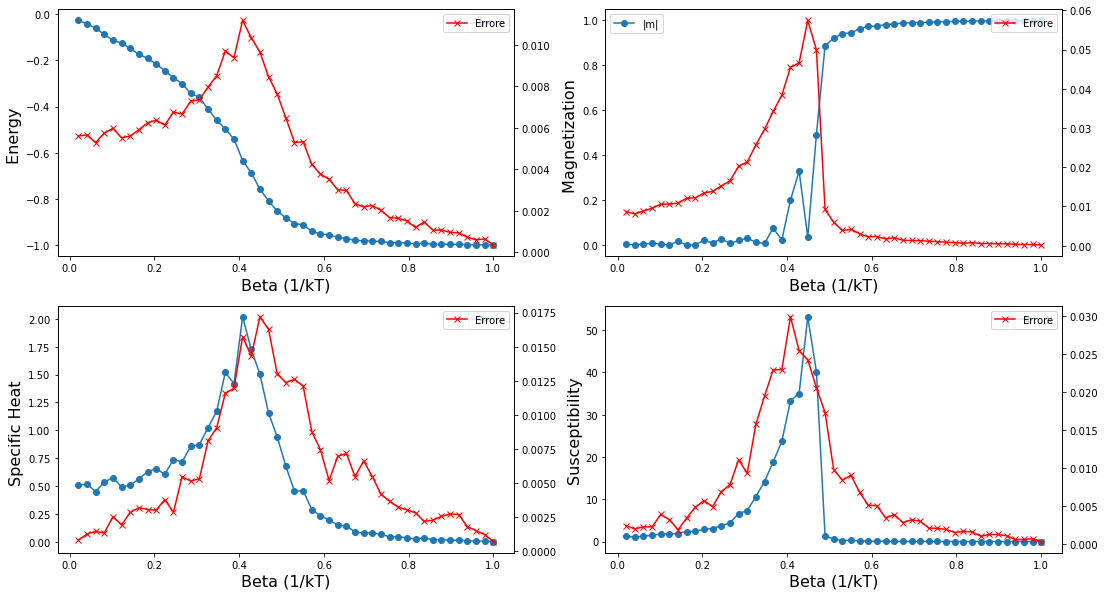

In [24]:
#collapse
beta3=beta[1:]
E3=E[1:]
errE3=np.sqrt(varE[1:])
M3=M[1:]
errM3=np.sqrt(varM[1:])
C3=C[1:]
errC3=np.sqrt(varC[1:])
X3=X[1:]
errX3=np.sqrt(varX[1:])

f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 )
plt.plot(beta3, E3, marker='o',label='e')
plt.legend()
plt.xlabel("Beta (1/kT)", fontsize=16)
plt.ylabel("Energy ", fontsize=16)       
plt.twinx()
plt.plot(beta3,errE3,color="r", marker='x',label='Errore')
plt.legend()

sp =  f.add_subplot(2, 2, 2 )
plt.plot(beta3, abs(M3), marker='o',label='|m|')
plt.legend()
plt.xlabel("Beta (1/kT)", fontsize=16)
plt.ylabel("Magnetization ", fontsize=16)
plt.twinx()
plt.plot(beta3,errM3,color="r", marker='x',label='Errore')
plt.legend()

sp =  f.add_subplot(2, 2, 3 )
plt.plot(beta3, C3, marker='o',label='c')
plt.legend()
plt.xlabel("Beta (1/kT)", fontsize=16)
plt.ylabel("Specific Heat ", fontsize=16)
plt.twinx()
plt.plot(beta3,errC3,color="r", marker='x',label='Errore')
plt.legend()

sp =  f.add_subplot(2, 2, 4 )
plt.plot(beta3, X3, marker='o',label="X")
plt.legend()
plt.xlabel("Beta (1/kT)", fontsize=16) 
plt.ylabel("Susceptibility", fontsize=16)
plt.twinx()
plt.plot(beta3,errX3,color="r", marker='x',label='Errore')
plt.legend()

plt.show()

Possiamo notare che i grafici mostrano lo stesso andamento che nel caso precedente, in particolare presentano una transizione di fase per un valore di $\beta$ molto simile a quello del modello di Ising, intorno a 0.44. 

A questo punto procediamo con lo studio del Finite Size Scaling per verificare che siano conservate anche tutte le corrette proprietà di scaling nel punto critico, quindi andremo a calcolare le osservabili, anche stavolta insieme alle barre di errori, per varie taglie del sistema in modo da permettere l'analisi:

In [ ]:
#collapse
nB      = 40       #  number of points of beta
decSteps= 80       #  number of MC sweeps for decorrelation
mcSteps = 100      #  number of MC sweeps for calculation

beta    = np.linspace(0.3, 0.6, nB)
linell  = np.array([7,10,13])
Nell=linell.size

E,M,C,X,varE,varM,varC,varX = np.zeros((nB,Nell)), np.zeros((nB,Nell)), np.zeros((nB,Nell)), np.zeros((nB,Nell)), np.zeros((nB,Nell)), np.zeros((nB,Nell)), np.zeros((nB,Nell)), np.zeros((nB,Nell))

for Ni in range(Nell):    # DIMENSIONI VARIABILI
    L=linell[Ni]
    N=AdD(2,L)[1]
    A=AdD(2,L)[0]
    
    mn1, mm, nn  = 1.0/(mcSteps*N), 1.0/(mcSteps*(mcSteps-1)) , 1/(N)

    config = initialstate2(N)

    for bb in range(1,nB):

        Ene=np.zeros(mcSteps)
        Mag=np.zeros(mcSteps)

        iB=beta[bb]; iB2=iB*iB;

        for i in range(mcSteps):         
            for j in range(decSteps):       # steps of decorrelation
                mcmove2(config, iB, A)          # Metropolis step

            Ene[i] = calcEnergy2(config)     # calculate the energy
            Mag[i] = calcMag(config)        # calculate the magnetization


        E[bb,Ni] = np.sum(Ene)*mn1
        varE[bb,Ni] = np.sum((Ene*nn-E[bb,Ni])**2)*mm
        M[bb,Ni] = np.sum(Mag)*mn1
        varM[bb,Ni] = np.sum((Mag*nn-M[bb,Ni])**2)*mm
        C[bb,Ni] = Di(Ene)
        varC[bb,Ni]=boots(Ene,50,8)
        X[bb,Ni] = Di(Mag)
        varX[bb,Ni]=boots(Mag,50,8)

        
        

beta4=beta[1:]
E4=E[1:]
M4=M[1:]
C4=C[1:]
X4=X[1:]




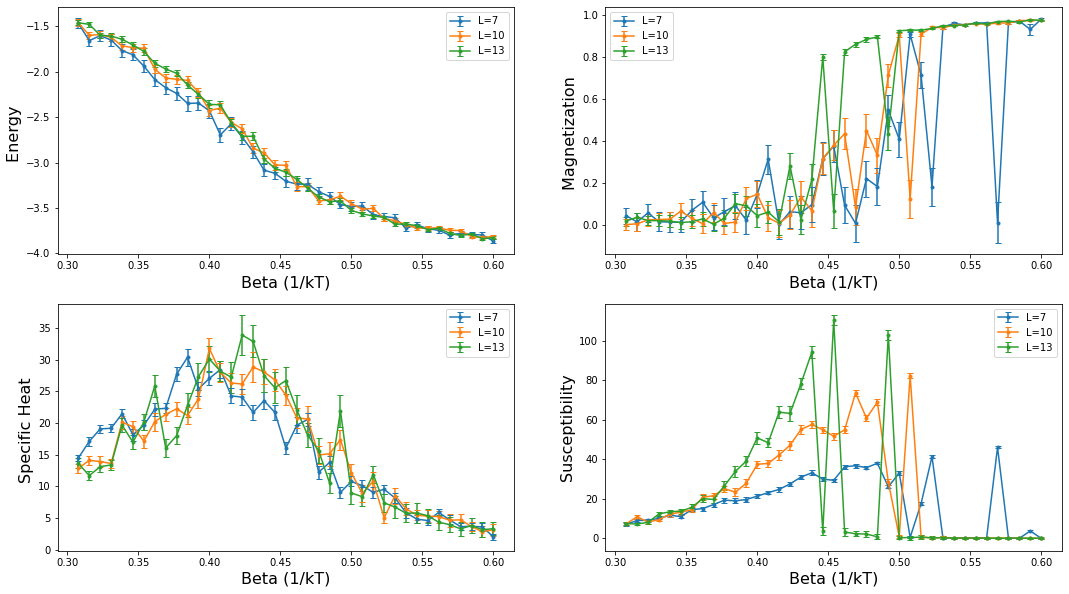

In [64]:
#collapse
import matplotlib as mpl
mpl.rcParams['errorbar.capsize'] = 3

errE4=np.sqrt(varE[1:])
errM4=np.sqrt(varM[1:])
errC4=np.sqrt(varC[1:]*100)
errX4=np.sqrt(varX[1:]*100*100)

f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 )
for i in range(Nell):
    plt.errorbar(beta4, E4[:,i],yerr=errE4[:,i],label="L="+str(linell[i]), marker='.')
plt.xlabel("Beta (1/kT)", fontsize=16)
plt.ylabel("Energy ", fontsize=16)       
plt.legend()

sp =  f.add_subplot(2, 2, 2 )
for i in range(Nell):
    plt.errorbar(beta4, abs(M4)[:,i],yerr=errM4[:,i],label="L="+str(linell[i]), marker='.')
plt.xlabel("Beta (1/kT)", fontsize=16)
plt.ylabel("Magnetization ", fontsize=16)
plt.legend()

sp =  f.add_subplot(2, 2, 3 )
for i in range(Nell):
    plt.errorbar(beta4, C4[:,i],yerr=errC4[:,i],label="L="+str(linell[i]), marker='.')
plt.xlabel("Beta (1/kT)", fontsize=16)
plt.ylabel("Specific Heat ", fontsize=16)
plt.legend()

sp =  f.add_subplot(2, 2, 4 )
for i in range(Nell):
    plt.errorbar(beta4, X4[:,i],yerr=errX4[:,i],label="L="+str(linell[i]), marker='.')
plt.xlabel("Beta (1/kT)", fontsize=16) 
plt.ylabel("Susceptibility", fontsize=16)
plt.legend()

plt.show()

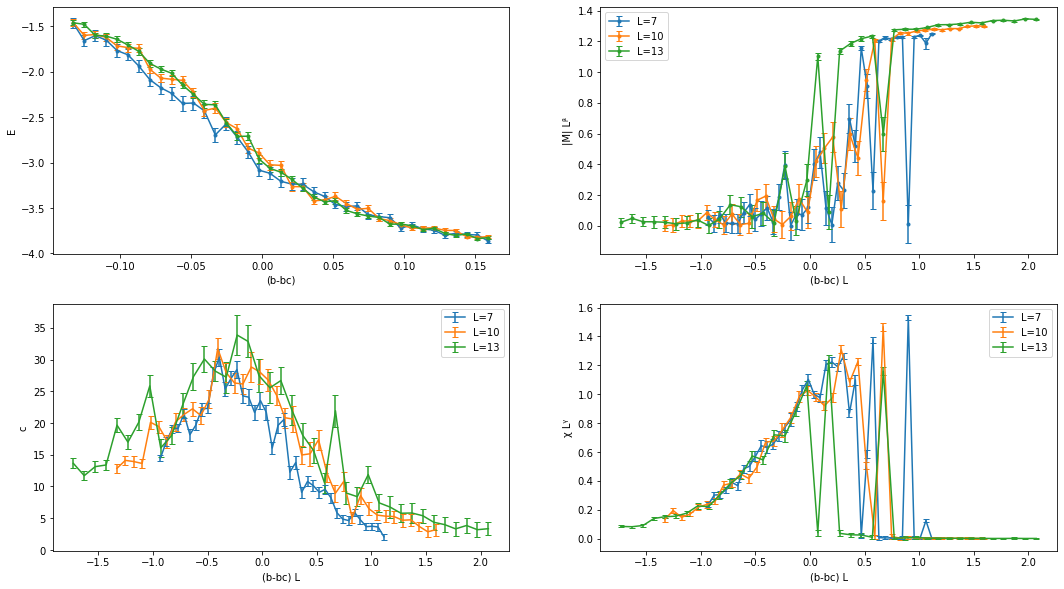

In [92]:
#collapse


Fmagniz=np.zeros((nB,Nell))
Fxi=np.zeros((nB,Nell))
Flins=np.zeros((nB,Nell))
FC=np.zeros((nB,Nell))
FerrE=np.zeros((nB,Nell))
FerrM=np.zeros((nB,Nell))
FerrX=np.zeros((nB,Nell))
FerrC=np.zeros((nB,Nell))

ell1=0
for ell in linell:

    Fmagniz[1:,ell1]=abs(M4)[:,ell1].copy()*(ell)**(1/8)
    Fxi[1:,ell1]=X4[:,ell1].copy()/(ell)**(7/4)
    FC[1:,ell1]=C4[:,ell1].copy()
    Flins[1:,ell1]=(beta4.copy()-0.4406868)*ell
    FerrE[1:,ell1]=errE4[:,ell1].copy()
    FerrM[1:,ell1]=errM4[:,ell1].copy()*(ell)**(1/8)
    FerrX[1:,ell1]=errX4[:,ell1].copy()/(ell)**(7/4)
    FerrC[1:,ell1]=errC4[:,ell1].copy()
    
    ell1+=1

plt.figure(figsize=(18, 10))

plt.subplot(221)
for i in range(Nell):

    plt.errorbar(beta4-0.4406868, E4[:,i],yerr=errE4[:,i],label="L="+str(linell[i]), marker='.')
plt.xlabel('(b-b𝖼)')
plt.ylabel('E')

plt.subplot(222)
for i in range(Nell):
    #plt.plot(beta2[1:], abs(M2[1:,i]), marker='o',label=linell[i])
    plt.errorbar(Flins[1:,i], Fmagniz[1:,i],yerr=FerrM[1:,i],label="L="+str(linell[i]), marker='.')
plt.xlabel('(b-b𝖼) L')
plt.ylabel('|M| Lᵝ')
plt.legend()


plt.subplot(223)
for i in range(Nell):
    #plt.plot(beta2[1:], C2[1:,i], marker='o',label=linell[i])
    plt.errorbar(Flins[1:,i], FC[1:,i],yerr=FerrC[1:,i],label="L="+str(linell[i]))
plt.xlabel('(b-b𝖼) L')
plt.ylabel('c')
plt.legend()


plt.subplot(224)
for i in range(Nell):
    
    plt.errorbar(Flins[1:,i], Fxi[1:,i],yerr=FerrX[1:,i],label="L="+str(linell[i]))
#plt.plot(Flins[1:],Fxi[1:],marker="o")
plt.xlabel('(b-b𝖼) L')
plt.ylabel('χ Lᵞ')
plt.legend()


plt.show()

Anche in questo caso possiamo notare come, nonostante le fluttuazioni statistiche, il sistema presenti le stesse caratteristiche critiche del modello di Ising 2D e possiamo dunque concludere che l'implementazione della matrice di adiacenza funziona correttamente e quindi procedere con lo studio dei sistemi con interazioni a lunga distanza random.

## Studio di sistemi con connessioni random

Per studiare questo tipo di sistemi verranno generate delle matrici di adiacenza attraverso la funzione *rand( )* della libreria SciPy che prende in input due numeri interi, relativi alle dimensioni della matrice, e un valore reale compreso tra 0 e 1 che indica la densità di elementi della matrice diversi da zero $\rho$. 

Nell'implementazione verrà generata una matrice con gli stessi parametri di input per ogni iterazione Metropolis, in maniera da considerare gli effetti già mediati e i corrispondenti errori. Il nostro scopo è studiare l'andamento delle osservabili del sistema, come in precedenza, mediando tra le possibili realizzazioni di una matrice random aventi gli stessi parametri di input, e quindi, in seguito, studiare gli andamenti al variare della densità di elementi diversi da zero.

La seguente simulazione studia la media dei sistemi a 8 elementi con densità di connessioni $\rho=1/8$.

In [ ]:
#collapse
nB      = 30       #  number of points of beta
decSteps= 100       #  number of MC sweeps for decorrelation
mcSteps = 500      #  number of MC sweeps for calculation

beta    = np.linspace(0, 5, nB)
N=8

E,M,C,X,varX,varC,varE,varM = np.zeros((nB)), np.zeros((nB)), np.zeros((nB)), np.zeros((nB)), np.zeros((nB)), np.zeros((nB)), np.zeros((nB)), np.zeros((nB))
mn1, mm, nn  = 1.0/(mcSteps*N), 1.0/(mcSteps*(mcSteps-1)) , 1/(N)

config = initialstate2(N)

for bb in range(1,nB):

    Ene=np.zeros(mcSteps)
    Mag=np.zeros(mcSteps)

    iB=beta[bb]; iB2=iB*iB;

    for i in range(mcSteps):   
        
        
        for j in range(decSteps):       # steps of decorrelation
            A=ss.rand(N,N,4/N).todok()
            mcmove2(config, iB, A)          # Metropolis step
            
        Ene[i] = calcEnergy2(config)     # calculate the energy
        Mag[i] = calcMag(config)        # calculate the magnetization

    E[bb] = np.sum(Ene)*mn1
    varE[bb] = np.sum((Ene*nn-E[bb])**2)*mm
    M[bb] = np.sum(Mag)*mn1
    varM[bb] = np.sum((Mag*nn-M[bb])**2)*mm
    C[bb] = Di(Ene)
    varC[bb]=boots(Ene,25,5)
    X[bb] = Di(Mag)
    varX[bb]=boots(Mag,25,5)

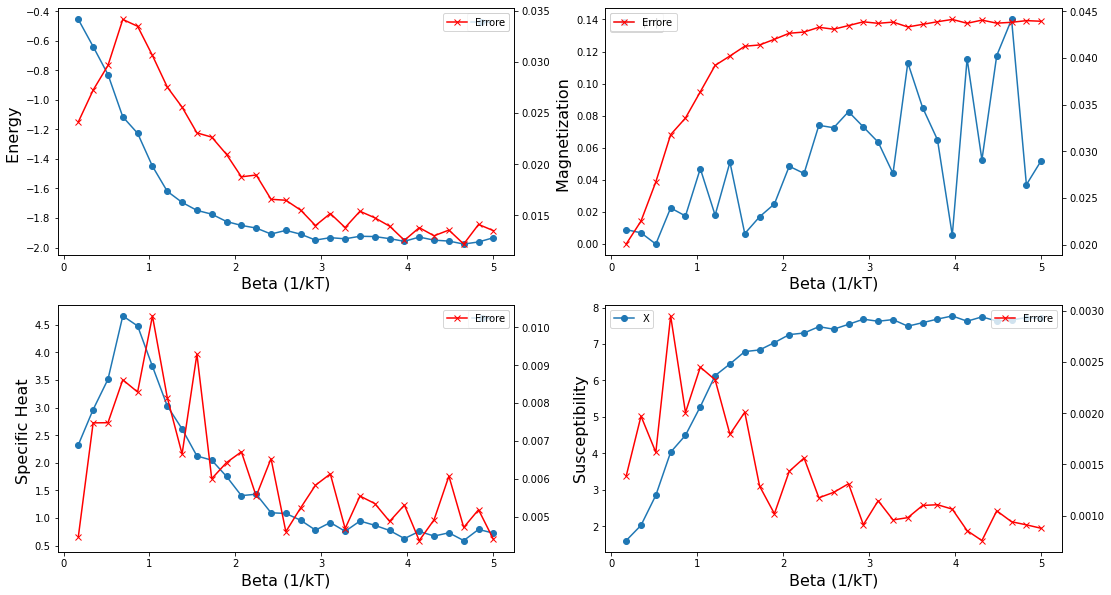

In [42]:
#collapse
beta5=beta[1:]
E5=E[1:]
errE5=np.sqrt(varE[1:])
M5=M[1:]
errM5=np.sqrt(varM[1:])
C5=C[1:]
errC5=np.sqrt(varC[1:])
X5=X[1:]
errX5=np.sqrt(varX[1:])

f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 )
plt.plot(beta5, E5, marker='o',label='e')
plt.legend()
plt.xlabel("Beta (1/kT)", fontsize=16)
plt.ylabel("Energy ", fontsize=16)       
plt.twinx()
plt.plot(beta5,errE5,color="r", marker='x',label='Errore')
plt.legend()

sp =  f.add_subplot(2, 2, 2 )
plt.plot(beta5, abs(M5), marker='o',label='|m|')
plt.legend()
plt.xlabel("Beta (1/kT)", fontsize=16)
plt.ylabel("Magnetization ", fontsize=16)
plt.twinx()
plt.plot(beta5,errM5,color="r", marker='x',label='Errore')
plt.legend()

sp =  f.add_subplot(2, 2, 3 )
plt.plot(beta5, C5, marker='o',label='c')
plt.legend()
plt.xlabel("Beta (1/kT)", fontsize=16)
plt.ylabel("Specific Heat ", fontsize=16)
plt.twinx()
plt.plot(beta5,errC5,color="r", marker='x',label='Errore')
plt.legend()

sp =  f.add_subplot(2, 2, 4 )
plt.plot(beta5, X5, marker='o',label="X")
plt.legend()
plt.xlabel("Beta (1/kT)", fontsize=16) 
plt.ylabel("Susceptibility", fontsize=16)
plt.twinx()
plt.plot(beta5,errX5,color="r", marker='x',label='Errore')
plt.legend()

plt.show()

Possiamo notare che i grafici dell'energia e del calore specifico ricordano in forma quelli precedenti, facendo pensare all'esistenza di un punto critico intorno a $\beta=1$ dove possiamo trovare il picco del calore specifico e degli errori in entrambi i grafici, ma in questo caso la magnetizzazione e la suscettività assumono valori anomali.

Il problema potrebbe essere dovuto ad un errore nell'implementazione anche se le verifiche sul modello di Ising sembrano corrette. 

La causa invece *non dovrebbe* essere lo scarso numero di misurazioni in quanto incrementandoli non è stato visto nessun cambiamento qualitativo.

Una possibile spiegazione, ma poco verosimile, è che il codice sia giusto e che i grafici relativi alla magnetizzazione, suscettività e corrispondenti errori siano corretti. In questo caso sorgerebbe il problema della corrispondenza con il modello quantistico. Infatti secondo il Quantum to Classical Mapping il modello di Ising 2D classico appartiene alla stessa classe di universalità del modello di Ising 1D quantistico. Nella relazione relativa al Modulo 2 ho studiato gli stessi network random ma da un punto di vista quantistico, ed essi presentano una transizione di fase ben definita. Il problema potrebbe risiedere nel fatto che il Quantum to Classical Mapping fa corrispondere sistemi quantistici d-dimensionali a sistemi classici di dimensione d+1, ma, secondo quanto detto per l'introduzione della matrice di adiacenza, entrambi i modelli si possono interpretare come giacenti su una varietà unidimensionale, ma soggetti a interazioni a lunga distanza, quindi entrambi della stessa dimensione uguale ad 1 e perciò il Quantum to Classical Mapping potrebbe non valere per questo tipo di network random. 

In ogni caso per raggiungere delle spiegazioni definitive sarebbero necessari numerosi altri studi, possibilmente molto più precisi.